In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import pandas as pd
import numpy as np

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
class DigitDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):
        self.data = data.reset_index(drop=True)  # Ensure data indices are sequential
        self.labels = labels.reset_index(drop=True) if labels is not None else None  # Same for labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx].values.astype('float32').reshape(28, 28, 1)  # Reshaping for grayscale images
        if self.transform:
            image = self.transform(image)
        
        if self.labels is not None:
            label = self.labels.iloc[idx]  # Ensure correct indexing for labels
            return image, label
        else:
            return image

In [9]:
df_train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
df_test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

# Split features and labels for training data
X = df_train.iloc[:, 1:]
y = df_train.iloc[:, 0]

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure that the indices are correctly aligned and reset for all DataFrames.
X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)

In [11]:
# Define Transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [12]:
# Prepare PyTorch Datasets and DataLoaders
train_dataset = DigitDataset(X_train, y_train, transform=train_transform)
valid_dataset = DigitDataset(X_valid, y_valid, transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


In [13]:
# Define a Simple Model (Adjust as Needed)
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # 10 output classes (digits 0-9)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


In [14]:
# Initialize Model, Criterion, Optimizer, and Scheduler
model = DigitClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch 1/10: 100%|██████████| 1050/1050 [00:23<00:00, 44.56it/s]


Epoch [1/10], Loss: 0.3310


Epoch 2/10: 100%|██████████| 1050/1050 [00:22<00:00, 46.13it/s]


Epoch [2/10], Loss: 0.0982


Epoch 3/10: 100%|██████████| 1050/1050 [00:22<00:00, 46.00it/s]


Epoch [3/10], Loss: 0.0491


Epoch 4/10: 100%|██████████| 1050/1050 [00:23<00:00, 45.60it/s]


Epoch [4/10], Loss: 0.0307


Epoch 5/10: 100%|██████████| 1050/1050 [00:22<00:00, 45.96it/s]


Epoch [5/10], Loss: 0.0201


Epoch 6/10: 100%|██████████| 1050/1050 [00:22<00:00, 45.88it/s]


Epoch [6/10], Loss: 0.0172


Epoch 7/10: 100%|██████████| 1050/1050 [00:22<00:00, 45.93it/s]


Epoch [7/10], Loss: 0.0166


Epoch 8/10: 100%|██████████| 1050/1050 [00:22<00:00, 45.89it/s]


Epoch [8/10], Loss: 0.0104


Epoch 9/10: 100%|██████████| 1050/1050 [00:22<00:00, 45.88it/s]


Epoch [9/10], Loss: 0.0118


Epoch 10/10: 100%|██████████| 1050/1050 [00:22<00:00, 45.94it/s]

Epoch [10/10], Loss: 0.0083


In [16]:
# Save the Final Model
torch.save(model.state_dict(), "digit_model.pth")
print("Training complete! Final model saved as digit_model.pth.")

Training complete! Final model saved as digit_model.pth.


In [17]:
def evaluate_model(model, valid_loader, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():  # Disable gradient calculation, saving memory and computations
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class (highest probability)

            y_true.extend(labels.cpu().numpy())  # Store true labels
            y_pred.extend(predicted.cpu().numpy())  # Store predicted labels

    # Convert to numpy arrays for metric calculations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Precision, Recall, F1 Score (can use micro or macro averaging depending on the use case)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, cm

# Example usage:
accuracy, precision, recall, f1, cm = evaluate_model(model, valid_loader, device)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")
print(f"Confusion Matrix:\n{cm}")


Accuracy: 0.9593
Precision (Macro): 0.9590
Recall (Macro): 0.9593
F1 Score (Macro): 0.9590
Confusion Matrix:
[[788   1   2   0   0   2  12   5   2   4]
 [  0 899   2   1   0   0   2   3   2   0]
 [  0   9 809   6   5   0   3   5   9   0]
 [  2   2   3 875   0  19   1   4  20  11]
 [  1   3   1   0 802   0   8   4   4  16]
 [  4   0   0   8   0 666  12   0  10   2]
 [  2   0   1   0   0   2 774   0   6   0]
 [  0   3   3   3   4   2   0 870   4   4]
 [  5   3   3   5   4   7   7   1 793   7]
 [  3   2   2   4  12   6   0  22   5 782]]


In [18]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
def predict(model, image_path, device):
    # Define the transform to be applied to the image (same as used in training)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128, 128)),  # Ensure matching resize
        transforms.Grayscale(num_output_channels=1),  # Grayscale for single channel
        transforms.ToTensor(),  # Convert to tensor
    ])

    # Load and preprocess the image
    image = Image.open(image_path)
    original_image = image.copy()  # Keep the original image to display later
    image = transform(np.array(image)).unsqueeze(0)  # Add batch dimension

    # Move the image to the same device as the model (GPU or CPU)
    image = image.to(device)

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():  # No need for gradients during prediction
        output = model(image)
        _, predicted_class = torch.max(output, 1)  # Get the predicted class

    # Display the image and the prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(original_image, cmap='gray')  # Show the original image
    plt.title(f"Predicted Digit: {predicted_class.item()}")
    plt.axis('off')  # Remove axis for better visualization
    plt.show()


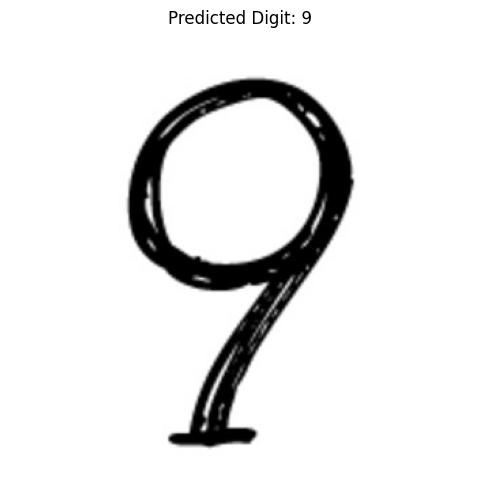

Predicted Digit: None


In [19]:
# Example usage
image_path = "/kaggle/input/test-digit/digit/digit9.jpg"  # Provide the path to your image
predicted_digit = predict(model, image_path, device)
print(f"Predicted Digit: {predicted_digit}")